<h1> Web Scrapping for BA </h1>

In [70]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random
import re

def get_rating_value(container, class_name):
    rating_elements = container.select(f".review-rating-header.{class_name} + .review-rating-stars span.fill")
    return len(rating_elements)

def get_review_data(soup):
    review_containers = soup.find_all("table", class_="review-ratings")

    for container in review_containers:
        type_of_traveller = container.find("td", class_="type_of_traveller")
        type_of_traveller_text = type_of_traveller.find_next_sibling("td").text.strip() if type_of_traveller else ""
        
        seat_type = container.find("td", class_="cabin_flown")
        seat_type_text = seat_type.find_next_sibling("td").text.strip() if seat_type else ""
        
        route = container.find("td", class_="route")
        route_text = route.find_next_sibling("td").text.strip() if route else ""
        
        date_flown = container.find("td", class_="date_flown")
        date_flown_text = date_flown.find_next_sibling("td").text.strip() if date_flown else ""
        
        seat_comfort = get_rating_value(container, "seat_comfort")
        cabin_staff_service = get_rating_value(container, "cabin_staff_service")
        ground_service = get_rating_value(container, "ground_service")
        value_for_money = get_rating_value(container, "value_for_money")
        food_and_beverages = get_rating_value(container, "food_and_beverages")
        inflight_entertainment = get_rating_value(container, "inflight_entertainment")
        
        recommended = container.find("td", class_="recommended")
        recommended_text = recommended.find_next_sibling("td").text.strip() if recommended else ""

        yield {
            "Type of Traveller": type_of_traveller_text,
            "Seat Type": seat_type_text,
            "Route": route_text,
            "Date Flown": date_flown_text,
            "Seat Comfort": seat_comfort,
            "Cabin Staff Service": cabin_staff_service,
            "Ground Service": ground_service,
            "Value for Money": value_for_money,
            "Food & Beverages": food_and_beverages,
            "Inflight Entertainment": inflight_entertainment,
            "Recommended": recommended_text,
            "Text Review": ""  # Placeholder for the text review
        }

def scrape_data(pages):
    url_template = "https://www.airlinequality.com/airline-reviews/british-airways/page/{}/"

    for page in pages:
        url = url_template.format(page)
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")

        # Extract the text reviews and verifications
        text_reviews = [para.get_text().strip() for para in soup.find_all("div", {"class": "text_content"})]
        verifications = [re.sub(r'[^\x00-\x7F]+', '', review.split("|")[0].strip()) if "|" in review else "" for review in text_reviews]

        for data, review, verification in zip(get_review_data(soup), text_reviews, verifications):
            data["Text Review"] = review.split("|", 1)[-1].strip() if "|" in review else review
            data["Verification"] = verification

            yield data

        # Random delay between 1 and 3 seconds
        time.sleep(random.uniform(1, 5))

def main():
    num_pages = 360
    pages = random.sample(range(1, num_pages + 1), num_pages)  # Randomly select pages to scrape

    df = pd.DataFrame(scrape_data(pages))

    # Replace 0 with NaN
    df.replace(0, float("NaN"), inplace=True)
    
    # Drop rows where 3 or more values are missing
    df.dropna(thresh=df.shape[1] - 2, inplace=True)

    # Save the DataFrame to a CSV file
    df.to_csv("british_airways_reviews.csv", index=False)

    # Save the DataFrame as Final_df
    df.to_csv("Final_df.csv", index=False)

    print("Data has been successfully scraped, cleaned, and saved to 'british_airways_reviews.csv' and 'Final_df.csv'.")

if __name__ == "__main__":
    main()


Data has been successfully scraped, cleaned, and saved to 'british_airways_reviews_cleaned.csv'.


In [6]:
df = pd.read_csv(r"C:\Users\Plaksha\Desktop\Forage\british_airways_reviews.csv")

In [7]:
df.head()

,Type of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Ground Service,Value for Money,Food & Beverages,Inflight Entertainment,Recommended
0,Solo Leisure,Economy Class,Bucharest to London Heathrow to Los Angeles,NaN,1,5,5.0,1.0,2.0,1.0,no
1,Business,Business Class,London to Miami,NaN,1,2,3.0,1.0,1.0,1.0,no
2,Business,Premium Economy,London to Calgary,NaN,3,3,4.0,2.0,3.0,4.0,yes
3,Business,Premium Economy,Calgary to London,NaN,3,4,3.0,2.0,3.0,3.0,no
4,Business,Premium Economy,Bangalore to London,NaN,2,2,2.0,1.0,2.0,1.0,no


<h1>Data Cleaning</h1>

In [29]:
df1 = pd.read_csv("Final_df.csv")

In [32]:
df1.fillna("NA", inplace=True)

In [33]:
df1["Recommended"] = df1["Recommended"].replace({"yes": 1, "no": 0})


In [37]:
count_values = df1["Recommended"].value_counts()
count_values

0    1822
1    1312
Name: Recommended, dtype: int64

From the analysis of the "Recommended" column in the DataFrame, we can observe that the majority of passengers, 1822 out of 3134 (58.1%), have not recommended the service to others. Only 1312 passengers (41.9%) have recommended it. This indicates that a significant portion of the passengers expressed dissatisfaction with the service and would not recommend it to others.

In [43]:
import pandas as pd
from tabulate import tabulate

df1["Recommended"] = df1["Recommended"].replace({"yes": 1, "no": 0})

# Group by "Route" and calculate the percentage of "yes" and "no" recommendations
route_grouped = df1.groupby("Route")["Recommended"].mean() * 100
route_grouped = route_grouped.rename("Percentage (%)")
route_counts = df1["Route"].value_counts()

route_data = pd.concat([route_grouped, route_counts], axis=1)
route_data = route_data.rename(columns={"Route": "Count"})
route_data = route_data.sort_values(by="Percentage (%)", ascending=False)

print("Percentage of Recommendations by Route:")
print(tabulate(route_data, headers="keys", tablefmt="psql"))
print()



# Group by both "Route" and "Seat Type" and calculate the percentage of "yes" and "no" recommendations
combined_grouped = df1.groupby(["Route", "Seat Type"])["Recommended"].mean() * 100
combined_grouped = combined_grouped.rename("Percentage (%)")
combined_counts = df1.groupby(["Route", "Seat Type"]).size()

combined_data = pd.concat([combined_grouped, combined_counts], axis=1)
combined_data = combined_data.rename(columns={0: "Count"})
combined_data = combined_data.sort_values(by="Percentage (%)", ascending=False)

print("Percentage of Recommendations by Route and Seat Type:")
print(tabulate(combined_data, headers="keys", tablefmt="psql"))


Percentage of Recommendations by Route:
+------------------------------------------------+------------------+---------+
|                                                |   Percentage (%) |   Count |
|------------------------------------------------+------------------+---------|
| lgw to alicante                                |         100      |       1 |
| Fuereventura to LGW                            |         100      |       1 |
| Gatwick to Bari                                |         100      |       2 |
| LCY to JFK via Shannon                         |         100      |       1 |
| LCY to RTM                                     |         100      |       1 |
| Gatwick to Antigua                             |         100      |       1 |
| Munich to London                               |         100      |       1 |
| GVA to PEK via LHR                             |         100      |       1 |
| SJC to LHR                                     |         100      |       1 |


In [61]:
# Group by "Seat Type" and calculate the percentage of "yes" and "no" recommendations
seat_type_grouped = df1.groupby("Seat Type")["Recommended"].mean() * 100
seat_type_grouped = seat_type_grouped.rename("Percentage (%)")
seat_type_counts = df1["Seat Type"].value_counts()

seat_type_data = pd.concat([seat_type_grouped, seat_type_counts], axis=1)
seat_type_data = seat_type_data.rename(columns={"Seat Type": "Count"})
seat_type_data = seat_type_data.sort_values(by="Percentage (%)", ascending=False)

print("Percentage of Recommendations by Seat Type:")
print(tabulate(seat_type_data, headers="keys", tablefmt="psql"))
print()

Percentage of Recommendations by Seat Type:
+-----------------+------------------+---------+
|                 |   Percentage (%) |   Count |
|-----------------+------------------+---------|
| First Class     |          48.6631 |     187 |
| Business Class  |          47.2868 |    1032 |
| Premium Economy |          41.5335 |     313 |
| Economy Class   |          37.664  |    1601 |
| NA              |           0      |       1 |
+-----------------+------------------+---------+



<H1>Insights</h1>

First Class, with least travellors, has the highest recommendation percentage among all seat types, with a recommendation rate of approximately 48.66%. This indicates that a significant portion of passengers in First Class were satisfied with the service and would recommend it to others.

Business Class also received a relatively high recommendation rate of around 47.29%. This suggests that Business Class passengers generally had a positive experience and are likely to recommend the service.

Premium Economy has a lower recommendation percentage of approximately 41.53%. While still above 40%, it indicates that a considerable number of Premium Economy passengers may not have been as satisfied with the service compared to First and Business Class travelers.

Economy Class which has most travelled passenger has received the lowest recommendation percentage of about 37.66%. This implies that a significant proportion of Economy Class passengers expressed dissatisfaction with the service or were less likely to recommend it to others compared to passengers in other classes.

In [44]:
import pandas as pd
from tabulate import tabulate


df1["Recommended"] = df1["Recommended"].replace({"yes": 1, "no": 0})


route_counts = df1["Route"].value_counts()

route_grouped = df1.groupby("Route")["Recommended"].mean() * 100

route_data = pd.DataFrame({"Route": route_counts.index, "Count": route_counts.values, "Percentage (%)": route_grouped.values})

route_data = route_data.sort_values(by="Percentage (%)", ascending=False)

print("Number of Unique Routes and Percentage of Recommendations:")
print(tabulate(route_data, headers="keys", tablefmt="psql"))


Number of Unique Routes and Percentage of Recommendations:
+------+------------------------------------------------+---------+------------------+
|      | Route                                          |   Count |   Percentage (%) |
|------+------------------------------------------------+---------+------------------|
| 1367 | Rio De Janeiro to London Heathrow              |       1 |         100      |
|  273 | London City to Edinburgh                       |       2 |         100      |
|  301 | Gatwick to Cape Town                           |       2 |         100      |
|  493 | London Heathrow to Seattle Tacoma              |       1 |         100      |
|  494 | Los Angeles to London to Paris to Rome         |       1 |         100      |
|  298 | London to Mexico City                          |       2 |         100      |
| 1054 | London to Lanzarote                            |       1 |         100      |
|  295 | London Heathrow to Vancouver                   |       2 |    

In [59]:
import pandas as pd
from tabulate import tabulate
# Filter out missing and "NA" values in the "Route" column
valid_routes = df1[df1["Route"].notna() & (df1["Route"] != "NA")]

# Count the occurrences of each route
route_counts = valid_routes["Route"].value_counts()

# Find the route with the maximum number of travelers
max_travelers_route = route_counts.idxmax()
max_travelers_count = route_counts.max()

filtered_df = df1.dropna(subset=["Route"], how="any")

# Count the number of travelers for each route
route_counts = filtered_df["Route"].value_counts()

# Find the route with the maximum number of travelers

recommendation_percentage = (max_travelers_df["Recommended"].mean()) * 100
recommendation_percentage = round(recommendation_percentage, 2)



print(f"The route with the maximum number of travelers is '{max_travelers_route}' with {max_travelers_count} travelers and has reccomendation of {recommendation_percentage} %")


The route with the maximum number of travelers is 'London to Johannesburg' with 15 travelers and has reccomendation of 56.89 %


In [69]:
df1["Type of Review"] = df1["Recommended"].map({1: "Positive Review", 0: "Negative Review"})

<H1>Analysis</h1>

<H3>Text Preprocessing using NLTK: Removing Stopwords, Pronouns, and Punctuation</h3>

In [74]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

nltk.download('stopwords')
nltk.download('punkt')

#list of pronouns to be removed
pronouns = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves"]

#set of punctuation characters to be removed
punctuation = '''!"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~'''

# Now here i am removing stop words, punctuation, and pronouns from the text
def preprocess_text(text):
    words = word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    words = [word.lower() for word in words if word.lower() not in stop_words and word not in punctuation]
    
    words = [word for word in words if word.lower() not in pronouns]
    cleaned_text = " ".join(words)
    return cleaned_text
df1["Cleaned Review"] = df1["Text Review"].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Plaksha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Plaksha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<H2>Analysis of Most Frequently Used Words in Positive and Negative Reviews</H2>

In [80]:
from collections import Counter

# Function to tokenize the cleaned text into words
def tokenize_text(text):
    return text.split()

# using cleaned reviews for positive and negative reviews
positive_reviews = df1[df1["Type of Review"] == "Positive Review"]["Cleaned Review"]
negative_reviews = df1[df1["Type of Review"] == "Negative Review"]["Cleaned Review"]

# Tokenizing the cleaned reviews into words
positive_words = positive_reviews.apply(tokenize_text).explode()
negative_words = negative_reviews.apply(tokenize_text).explode()

# Counting the occurrences of each word
positive_word_counts = Counter(positive_words)
negative_word_counts = Counter(negative_words)

# Finally, Getting the top 20 most frequently used words for positive and negative reviews
top_30_positive_words = positive_word_counts.most_common(30)
top_30_negative_words = negative_word_counts.most_common(30)

# Creating DataFrames to display the results in table format
top_30_positive_df = pd.DataFrame(top_30_positive_words, columns=["Word", "Frequency"])
top_30_negative_df = pd.DataFrame(top_30_negative_words, columns=["Word", "Frequency"])


print("Top 30 Most Frequent Words in Positive Reviews:")
print(tabulate(top_30_positive_df, headers="keys", tablefmt="psql", showindex=False))

Top 30 Most Frequent Words in Positive Reviews:
+------------+-------------+
| Word       |   Frequency |
|------------+-------------|
| flight     |        2211 |
| ba         |        1627 |
| service    |         975 |
| food       |         854 |
| seat       |         831 |
| seats      |         809 |
| crew       |         784 |
| good       |         750 |
| london     |         728 |
| british    |         719 |
| cabin      |         709 |
| airways    |         702 |
| time       |         702 |
| class      |         661 |
| n't        |         650 |
| business   |         566 |
| staff      |         562 |
| one        |         560 |
| would      |         517 |
| heathrow   |         515 |
| economy    |         494 |
| first      |         446 |
| club       |         432 |
| get        |         426 |
| 's         |         403 |
| flights    |         395 |
| could      |         394 |
| lounge     |         388 |
| return     |         380 |
| passengers |         3

<h2>Concise analysis based on the word frequencies:</h2>

<b>Service:</b> The word "service" is highly mentioned, suggesting that passengers appreciate and acknowledge the quality of service provided by British Airways.

<b>Food:</b> Passengers often talk about the food served on flights, indicating its significance in their overall experience.

<b>Seat / Seats:</b> The terms "seat" and "seats" are commonly used, highlighting the importance of comfort during the flight.

<b>Crew:</b> The word "crew" is mentioned frequently, indicating passengers' interactions and satisfaction with the airline's staff.

<b>Lounge:</b> The word "lounge" is mentioned 388 times in positive reviews. This indicates that passengers appreciate and value the lounge facilities provided by British Airways at various airports.

<b>London:</b> London, being a major hub for British Airways, is frequently referenced in the reviews.

<b>Cabin:</b> Passengers frequently mention the cabin, emphasizing the interior of the aircraft.


In [81]:
print("\nTop 30 Most Frequent Words in Negative Reviews:")
print(tabulate(top_30_negative_df, headers="keys", tablefmt="psql", showindex=False))


Top 30 Most Frequent Words in Negative Reviews:
+----------+-------------+
| Word     |   Frequency |
|----------+-------------|
| flight   |        3300 |
| ba       |        2379 |
| service  |        1405 |
| seat     |        1224 |
| food     |        1175 |
| london   |        1132 |
| airways  |        1115 |
| british  |        1114 |
| crew     |        1063 |
| good     |        1045 |
| time     |        1013 |
| seats    |        1011 |
| cabin    |         983 |
| n't      |         910 |
| class    |         893 |
| would    |         823 |
| heathrow |         804 |
| one      |         794 |
| staff    |         786 |
| business |         744 |
| economy  |         744 |
| get      |         685 |
| first    |         618 |
| could    |         574 |
| us       |         571 |
| flights  |         568 |
| 's       |         567 |
| return   |         566 |
| airline  |         549 |
| back     |         548 |
+----------+-------------+


<b>Service:</b> The word "service" is highly mentioned in negative reviews, indicating that passengers may have encountered issues with the quality of service provided by British Airways.

<b>Seat:</b> The term "seat" is frequently used, suggesting that passengers are dissatisfied with the seating comfort or arrangements during their flights.

<b>Food:</b> Passengers often mention "food" in negative reviews, indicating dissatisfaction with the meals or catering services provided by the airline.

<b>London:</b> "London" is frequently referenced, likely indicating issues or experiences related to flights departing from or arriving at London airports.

<b>Airways:</b> The term "airways" is mentioned, once again indicating specific feedback related to British Airways.

<b>Crew:</b> Passengers frequently mention the "crew," indicating that they may have encountered problems with the behavior or service provided by the airline's staff.

<h2>Word clouds for both positive and negative reviews</h2>

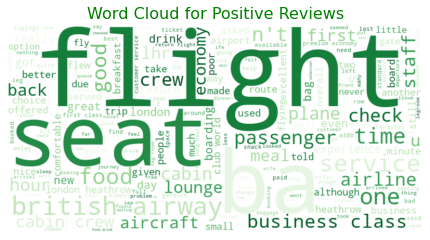

In [85]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_reviews = df1[df1["Type of Review"] == "Positive Review"]["Cleaned Review"]
negative_reviews = df1[df1["Type of Review"] == "Negative Review"]["Cleaned Review"]

positive_text = " ".join(positive_reviews)
negative_text = " ".join(negative_reviews)

# Creating WordCloud objects for positive and negative reviews
positive_wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="Greens").generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(negative_text)

# Plot the word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.title("Word Cloud for Positive Reviews", color="green", fontsize=16)
plt.axis("off")



plt.tight_layout()
plt.show()

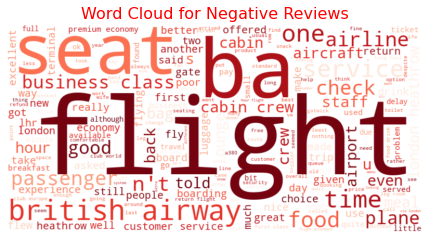

In [87]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.title("Word Cloud for Negative Reviews", color="red", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()

In [89]:
from textblob import TextBlob

def get_sentiment_polarity(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df1["Sentiment Polarity"] = df1["Cleaned Review"].apply(get_sentiment_polarity)

df1["Sentiment"] = df1["Sentiment Polarity"].apply(lambda x: "Positive" if x > 0 else ("Negative" if x < 0 else "Neutral"))

print(df1.head())


  Type of Traveller        Seat Type                         Route  \
0    Couple Leisure  Premium Economy                    LHR to PHX   
1    Couple Leisure    Economy Class          Gatwick to Barcelona   
2          Business   Business Class                    LHR to BRU   
3    Couple Leisure    Economy Class         Heathrow to Vancouver   
4    Couple Leisure    Economy Class  Glasgow to Cape Town via LHR   

       Date Flown  Seat Comfort  Cabin Staff Service Ground Service  \
0  September 2015           4.0                  5.0            4.0   
1  September 2015           1.0                  1.0            1.0   
2  September 2015           1.0                  2.0            3.0   
3       July 2015           2.0                  2.0            3.0   
4  September 2015           1.0                  3.0            3.0   

  Value for Money Food & Beverages Inflight Entertainment  Recommended  \
0             5.0              3.0                    2.0            0   
1   

In [90]:
df1.head()

,Type of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Ground Service,Value for Money,Food & Beverages,Inflight Entertainment,Recommended,Text Review,Verification,Type of Review,Cleaned Review,Sentiment Polarity,Sentiment
0,Couple Leisure,Premium Economy,LHR to PHX,September 2015,4.0,5.0,4.0,5.0,3.0,2.0,0,I have not got as far as even flying with Brit...,NA,Negative Review,got far even flying british airways time aroun...,-0.054545,Negative
1,Couple Leisure,Economy Class,Gatwick to Barcelona,September 2015,1.0,1.0,1.0,1.0,1.0,1.0,0,British Airways introduced its new Club Europe...,NA,Negative Review,british airways introduced new club europe bus...,-0.153994,Negative
2,Business,Business Class,LHR to BRU,September 2015,1.0,2.0,3.0,1.0,1.0,1.0,0,British Airways from Heathrow to Vancouver out...,NA,Negative Review,british airways heathrow vancouver outbound to...,0.203571,Positive
3,Couple Leisure,Economy Class,Heathrow to Vancouver,July 2015,2.0,2.0,3.0,3.0,1.0,1.0,0,Glasgow to Cape Town via Heathrow with British...,NA,Negative Review,glasgow cape town via heathrow british airways...,0.107440,Positive
4,Couple Leisure,Economy Class,Glasgow to Cape Town via LHR,September 2015,1.0,3.0,3.0,3.0,2.0,1.0,0,I have flown business class long haul on Emira...,NA,Negative Review,flown business class long haul emirates qatar ...,0.100000,Positive


In [92]:
count_values = df1["Sentiment"].value_counts()
count_values

Positive    2233
Negative     882
Neutral       19
Name: Sentiment, dtype: int64

In [94]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Function to perform sentiment analysis and return the sentiment compound score
def get_sentiment_score(text):
    analyzer = SentimentIntensityAnalyzer()
    return analyzer.polarity_scores(text)["compound"]

df1["Sentiment Score"] = df1["Cleaned Review"].apply(get_sentiment_score)

df1["Sentiment"] = df1["Sentiment Score"].apply(lambda x: "Positive" if x > 0 else ("Negative" if x < 0 else "Neutral"))




In [95]:
df1.head()

,Type of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Ground Service,Value for Money,Food & Beverages,Inflight Entertainment,Recommended,Text Review,Verification,Type of Review,Cleaned Review,Sentiment Polarity,Sentiment,Sentiment Score
0,Couple Leisure,Premium Economy,LHR to PHX,September 2015,4.0,5.0,4.0,5.0,3.0,2.0,0,I have not got as far as even flying with Brit...,NA,Negative Review,got far even flying british airways time aroun...,-0.054545,Negative,-0.8316
1,Couple Leisure,Economy Class,Gatwick to Barcelona,September 2015,1.0,1.0,1.0,1.0,1.0,1.0,0,British Airways introduced its new Club Europe...,NA,Negative Review,british airways introduced new club europe bus...,-0.153994,Negative,-0.9260
2,Business,Business Class,LHR to BRU,September 2015,1.0,2.0,3.0,1.0,1.0,1.0,0,British Airways from Heathrow to Vancouver out...,NA,Negative Review,british airways heathrow vancouver outbound to...,0.203571,Positive,0.0243
3,Couple Leisure,Economy Class,Heathrow to Vancouver,July 2015,2.0,2.0,3.0,3.0,1.0,1.0,0,Glasgow to Cape Town via Heathrow with British...,NA,Negative Review,glasgow cape town via heathrow british airways...,0.107440,Positive,0.9401
4,Couple Leisure,Economy Class,Glasgow to Cape Town via LHR,September 2015,1.0,3.0,3.0,3.0,2.0,1.0,0,I have flown business class long haul on Emira...,NA,Negative Review,flown business class long haul emirates qatar ...,0.100000,Negative,-0.2023


In [106]:
# List of columns to calculate the average score
score_columns = ["Seat Comfort", "Cabin Staff Service", "Ground Service", 
                 "Value for Money", "Food & Beverages", "Inflight Entertainment"]

df1[score_columns] = df1[score_columns].apply(pd.to_numeric, errors='coerce')
filtered_df = df1.dropna(subset=score_columns, how="all")

# Calculate the mean and median for each column
mean_scores = filtered_df[score_columns].mean()
median_scores = filtered_df[score_columns].median()

result_df = pd.DataFrame({"Mean Score": mean_scores,} )

print(tabulate(result_df, headers="keys", tablefmt="grid"))


+------------------------+--------------+
|                        |   Mean Score |
+========================+==============+
| Seat Comfort           |      2.88641 |
+------------------------+--------------+
| Cabin Staff Service    |      3.25495 |
+------------------------+--------------+
| Ground Service         |      2.84366 |
+------------------------+--------------+
| Value for Money        |      2.75072 |
+------------------------+--------------+
| Food & Beverages       |      2.71208 |
+------------------------+--------------+
| Inflight Entertainment |      2.66104 |
+------------------------+--------------+


Seat Comfort: Passengers rated seat comfort with an average score of 2.89 out of 5, indicating an acceptable but not exceptional level of comfort.

Cabin Staff Service: The cabin staff service received an average score of 3.25 out of 5, showing that passengers generally had a positive experience with the airline's cabin staff.

Ground Service: Ground service obtained an average score of 2.84 out of 5, indicating a relatively neutral perception of the airline's services at the ground level.

Value for Money: The value for money provided by the airline received an average score of 2.75 out of 5, suggesting a somewhat mixed perception of the services' worthiness relative to the cost.

Food & Beverages: Passengers rated the onboard food and beverages with an average score of 2.71 out of 5, indicating a somewhat mixed satisfaction level with the offerings.

Inflight Entertainment: The inflight entertainment options received an average score of 2.66 out of 5, suggesting a moderate level of satisfaction with the available entertainment choices.

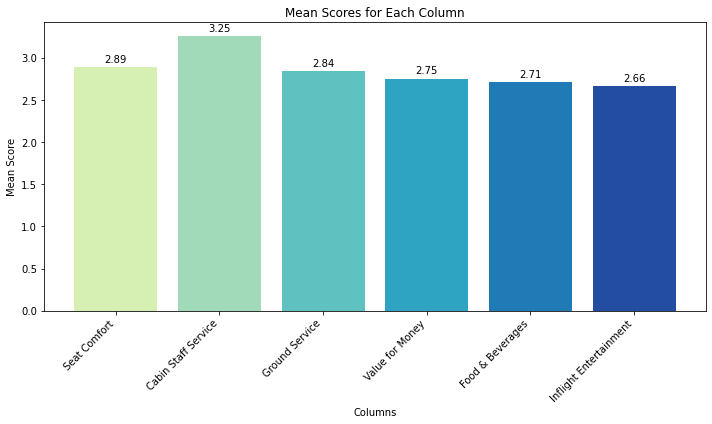

In [111]:
num_bars = len(mean_scores)
colors = plt.cm.YlGnBu(np.linspace(0.2, 0.8, num_bars))

# Plot the graph for the mean scores
plt.figure(figsize=(10, 6))
bars = plt.bar(mean_scores.index, mean_scores.values, color=colors)
plt.xlabel("Columns")
plt.ylabel("Mean Score")
plt.title("Mean Scores for Each Column")

# Add mean score values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.annotate(f"{height:.2f}", xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points",
                 ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()